In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy import stats
from scipy.integrate import trapezoid
import pysunnc as ps
from astropy.io import ascii
import pypopfit
import dynesty
from dynesty import plotting as dyplot
from multiprocessing import Pool

**Settings**

In [2]:
iso=ascii.read('../zziso/iso1.dat')
pt0=iso[np.abs(iso['logAge']-7.0)<1e-3]

bands=['F275W', 'F336W', 'F438W', 'F555W', 'F625W', 'F814W']

DM=30.0

gal_coeff={'F275W': 1.989, 'F336W': 1.633, 'F438W': 1.332,
           'F555W': 0.989, 'F625W': 0.866, 'F814W': 0.578}
int_coeff=gal_coeff.copy()

gal_Av=0.1
int_Av_avg=0.20
int_Av_std=0.05

lims={'F275W': 26.50, 'F336W': 27.00, 'F438W': 27.50,
      'F555W': 27.80, 'F625W': 28.00, 'F814W': 28.00}

**Generate simulated stars**

In [3]:
def imf(M):
    return M**(-2.35)

Ntot=300
Mmin=5
Mmax=100
Pbin=0.5

simtab=Table([], names=[])
#assign mass
Anorm=imf(Mmin)
simtab['M1']=np.zeros(int(Ntot), dtype=float)
for ii in range(len(simtab)):
    while True:
        mass=np.random.random()*(Mmax-Mmin)+Mmin
        prob=imf(mass)/Anorm
        if np.random.random()<prob:
            simtab[ii]['M1']=round(mass, 10) 
            break
#assign binary
simtab['isbin']=False
simtab['q']=0.0
simtab['M2']=0.0
for ii in range(len(simtab)):
    if np.random.random()<Pbin:
        simtab[ii]['isbin']=True
        simtab[ii]['q']=round(np.random.random(), 2)
simtab['M2']=np.around(simtab['M1']*simtab['q'], 10)

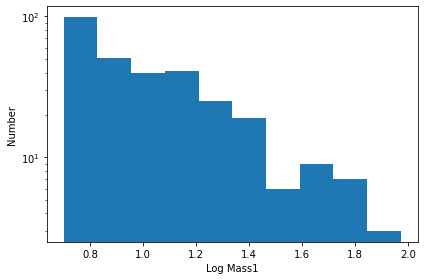

In [4]:
plt.close('all')
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xlabel('Log Mass1')
ax.set_ylabel('Number')
ax.hist(np.log10(simtab['M1']))
fig.tight_layout()

In [5]:
itps={}
for bd in bands:
    itps[bd]=interp1d(pt0['Mini'], pt0[bd+'mag'], fill_value=99.999, bounds_error=False)
int_Avs=np.maximum(0, int_Av_avg+np.random.randn(len(simtab))*int_Av_std)

magtab=Table([], names=[])
for bd in bands:
    # maggitude
    mag1=itps[bd](simtab['M1'])
    mag2=itps[bd](simtab['M2'])
    AAs=gal_coeff[bd]*gal_Av+int_coeff[bd]*int_Avs
    magtab[bd+'mag']=ps.addmag(mag1, mag2)+AAs+DM
    # photometric error
    logerr=(magtab[bd+'mag']-21)/(lims[bd]-21)*(np.log10(0.3)-np.log10(0.01))+np.log10(0.01)
    magtab[bd+'err']=np.around(10**logerr, 4)
    # add simulated errors to the magnitudes
    magtab[bd+'mag']=np.around(magtab[bd+'mag']+np.random.randn(len(magtab))*magtab[bd+'err'], 4)
    # detection?
    magtab[bd+'det']=0

for ii in range(len(magtab)):
    for bd in bands:
        if magtab[ii][bd+'err']<=0.2:
            magtab[ii][bd+'det']=1
        else:
            magtab[ii][bd+'det']=0
            magtab[ii][bd+'mag']=lims[bd]
            magtab[ii][bd+'err']=0.2
# remove non-detections
idxGood=np.zeros(len(magtab), dtype=bool)
for bd in bands:
    idxGood= idxGood | (magtab[bd+'det']==1)
magtab=magtab[idxGood]
magtab=magtab[np.argsort(magtab['F814Wmag'])]
print(len(magtab))

51


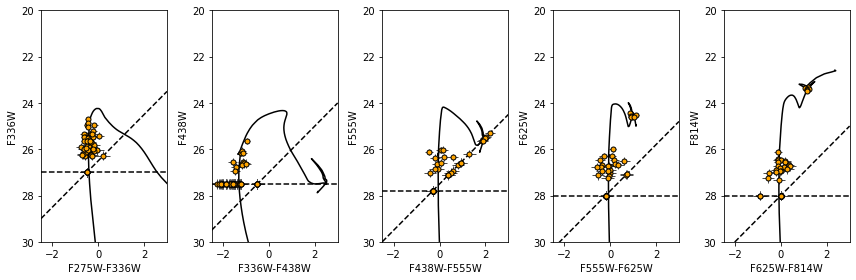

In [6]:
plt.close('all')
fig=plt.figure(figsize=[12, 4])
for ibd in range(len(bands)-1):
    ax=fig.add_subplot(1, len(bands)-1, ibd+1)
    bd1=bands[ibd]
    bd2=bands[ibd+1]
    ax.set_xlabel(bd1+'-'+bd2)
    ax.set_ylabel(bd2)
    ax.set_ylim(30, 20)
    ax.set_xlim(-2.5, 3)
    mag1, err1 = magtab[bd1+'mag'], magtab[bd1+'err']
    mag2, err2 = magtab[bd2+'mag'], magtab[bd2+'err']
    ax.errorbar(mag1-mag2, mag2,
                xerr=np.sqrt(err1**2+err2**2), yerr=err2,
                fmt='o', mfc='orange', mec='k', markersize=5,
                ecolor='0.3', elinewidth=1.0)
    mag1=pt0[bd1+'mag']+gal_coeff[bd1]*gal_Av+int_coeff[bd1]*int_Av_avg
    mag2=pt0[bd2+'mag']+gal_coeff[bd2]*gal_Av+int_coeff[bd2]*int_Av_avg
    ax.plot(mag1-mag2, mag2+DM, color='k')
    ax.axhline(y=lims[bd2], linestyle='--', color='k')
    ax.plot([-2.5, 3], [lims[bd1]+2.5, lims[bd1]-3], linestyle='--', color='k')
fig.tight_layout()

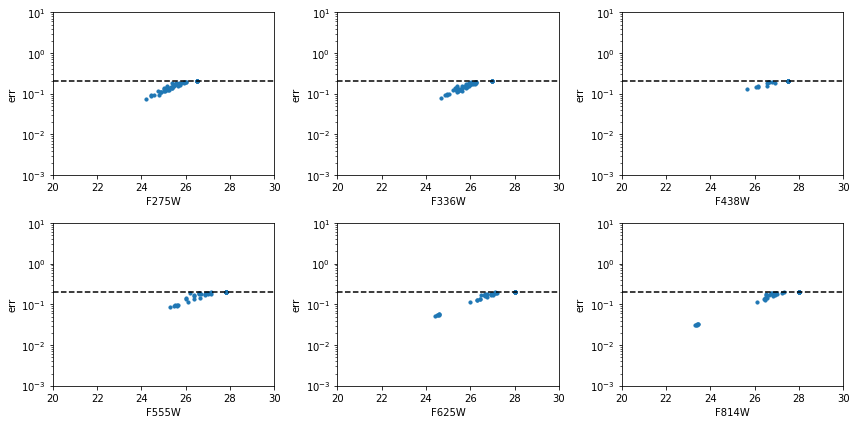

In [7]:
plt.close('all')
fig=plt.figure(figsize=[12, 6])
for ibd in range(len(bands)):
    bd=bands[ibd]
    ax=fig.add_subplot(2, 3, ibd+1)
    ax.set_xlabel(bd)
    ax.set_ylabel('err')
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 1e1)
    ax.set_xlim(20, 30)
    ax.axhline(y=0.2, color='k', linestyle='--')
    ax.scatter(magtab[bd+'mag'], magtab[bd+'err'], s=10)
fig.tight_layout()

In [8]:
magtab.write('../zzcat/cat3.dat', format='ascii', overwrite=True)

**Perform population fitting**

In [3]:
magtab=ascii.read('../zzcat/cat1.dat')

In [4]:
posts=[]
for ii in range(len(magtab)):
    LH1=ps.pload('../zzres1/'+str(ii)+'.dat')
    posts.append(LH1)
print(np.shape(posts[0]))

(100, 100)


In [7]:
Avbin=0.01
LAbin=0.01

LAs=np.around(np.arange(6.6, 7.6, 0.01), 2)
Avs=np.around(np.arange(0.0, 1.0, 0.01), 2)
Avmesh, LAmesh = np.meshgrid(Avs, LAs)

print(np.shape(LAmesh), np.shape(Avmesh))

(100, 100) (100, 100)


In [8]:
def Norm(x, mu, sig):
    return 1.0/np.sqrt(2*np.pi)/sig*np.exp(-0.5*((x-mu)/sig)**2)

def ptform(x):
    (xLA, xAv)=x
    pLA=xLA*(7.6-6.6)+6.6
    pAv=xAv*(1.0-0.0)+0.0
    # pAv=stats.truncnorm.ppf(xAv, (0-0.3)/0.01, (1-0.3)/0.01, loc=0.3, scale=0.01)
    return np.array([pLA, pAv])

def loglike(x):
    (LA, Av)=x
    LL=0.0
    for ii in range(len(posts)):
        LH0=posts[ii]+1e-30
        LAnorm=Norm(LAmesh, LA, 0.01)
        Avnorm=Norm(Avmesh, Av, 0.01)
        LL1=trapezoid(trapezoid(LH0*LAnorm*Avnorm, x=LAs, axis=0), x=Avs)
        LL=LL+np.log(LL1)
    return LL

# def ptform(x):
#     (xLA, xAv, xLogdAv)=x
#     pLA=xLA*(7.6-6.6)+6.6
#     pAv=xAv*(1.0-0.0)+0.0
#     # pAv=stats.truncnorm.ppf(xAv, (0-0.3)/0.01, (1-0.3)/0.01, loc=0.3, scale=0.01)
#     pLogdAv=xLogdAv*(1.0-0.0)+0.0
#     return np.array([pLA, pAv, pLogdAv])

# def loglike(x):
#     (LA, Av, LogdAv)=x
#     dAv=(10**LogdAv)*0.01
#     LL=0.0
#     for ii in range(len(posts)):
#         LAnorm=Norm(LAmesh, LA, 0.01)
#         Avnorm=Norm(Avmesh, Av, dAv)
#         LL1=trapezoid(trapezoid(posts[ii]*Avnorm*LAnorm, x=LAs, axis=0), x=Avs)
#         if LL1>0:
#             LL=LL+np.log(LL1)
#         else:
#             LL=LL-10000
#     return LL

In [9]:
pool=Pool(processes=48)
sampler=dynesty.DynamicNestedSampler(loglike, ptform, ndim=2, pool=pool, queue_size=48)
sampler.run_nested()
results=sampler.results
ps.pdump(results, '../zzres1/res1.dat')
pool.close()

iter: 20495 | batch: 10 | bound: 64 | nc: 5 | ncall: 63380 | eff(%): 32.337 | loglstar: -432.708 < -425.340 < -426.139 | logz: -432.771 +/-  0.156 | stop:  0.837                                     

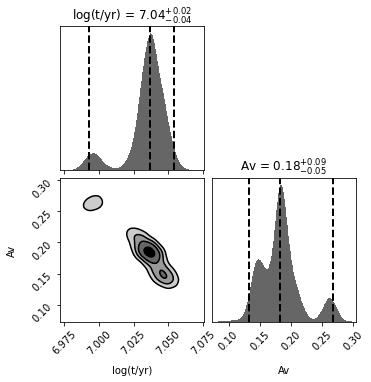

In [10]:
results=ps.pload('../zzres1/res1.dat')
# results=ps.pload('../zzres2/res2.dat')
# results=ps.pload('../zzres3/res3.dat')
(cfig, caxes)=dyplot.cornerplot(results, show_titles=True,
                                labels=['log(t/yr)', 'Av'])

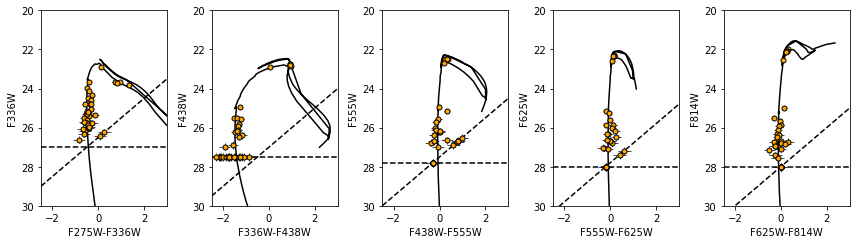

In [11]:
plt.close('all')

pt1=iso[np.abs(iso['logAge']-7.32)<1e-3]

fig=plt.figure(figsize=[12, 3.5])
for ibd in range(len(bands)-1):
    ax=fig.add_subplot(1, len(bands)-1, ibd+1)
    bd1=bands[ibd]
    bd2=bands[ibd+1]
    ax.set_xlabel(bd1+'-'+bd2)
    ax.set_ylabel(bd2)
    ax.set_ylim(30, 20)
    ax.set_xlim(-2.5, 3)
    mag1, err1 = magtab[bd1+'mag'], magtab[bd1+'err']
    mag2, err2 = magtab[bd2+'mag'], magtab[bd2+'err']
    ax.errorbar(mag1-mag2, mag2,
                xerr=np.sqrt(err1**2+err2**2), yerr=err2,
                fmt='o', mfc='orange', mec='k', markersize=5,
                ecolor='0.3', elinewidth=1.0)
    # isochrone - correct
    mag1=pt0[bd1+'mag']+gal_coeff[bd1]*gal_Av+int_coeff[bd1]*int_Av_avg
    mag2=pt0[bd2+'mag']+gal_coeff[bd2]*gal_Av+int_coeff[bd2]*int_Av_avg
    ax.plot(mag1-mag2, mag2+DM, color='k')
    # # isochrone - fitted
    # mag1=pt1[bd1+'mag']+gal_coeff[bd1]*gal_Av+int_coeff[bd1]*0.09
    # mag2=pt1[bd2+'mag']+gal_coeff[bd2]*gal_Av+int_coeff[bd2]*0.09
    # ax.plot(mag1-mag2, mag2+DM, color='r')
    # limit
    ax.axhline(y=lims[bd2], linestyle='--', color='k')
    ax.plot([-2.5, 3], [lims[bd1]+2.5, lims[bd1]-3], linestyle='--', color='k')
fig.tight_layout()

/local1/nsun/miniconda3/envs/astro3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


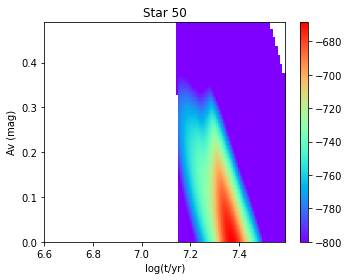

In [50]:
LH=np.zeros((len(LAs), len(Avs)), dtype=np.float32)
for ii in range(len(magtab)):
    LH1=posts[ii]
    LH=LH+np.log(LH1)
    # idxGood=(LH1>0)
    # if np.any(idxGood):
    #     LH[idxGood]=LH[idxGood]+np.log(LH1[idxGood])
    # if np.any(~idxGood):
    #     LH[~idxGood]=LH[~idxGood]-10000

plt.close('all')
fig=plt.figure(figsize=[5, 4]) 
ax=fig.add_subplot(111)
ax.set_title('Star '+str(ii))
ax.set_xlabel('log(t/yr)')
ax.set_ylabel('Av (mag)')
p=ax.imshow(np.transpose(LH), vmin=-800,
            extent=[np.amin(LAs), np.amax(LAs), np.amin(Avs), np.amax(Avs)],
            origin='lower', cmap='rainbow', aspect='auto')
fig.colorbar(p, ax=ax, aspect=30)
fig.tight_layout()